<h1><center>Deep Learning Project: Neural Image Captioning<center><h1>
<h2><center>Part II: captioning with visual attention<center><h2>

**Authors**: Ryan Boustany, Emma Sarfati  
**Teacher**: Marco Cuturi  
Deep Learning Course - ENSAE 3rd year  
$\texttt{ryan.boustany@ensae.fr}$ ⎜ $\texttt{emma.sarfati@ensae.fr}$

<h1><center>Abstract</center></h1>
    
In this second notebook, we propose an implementation of the paper of Xu et al. published in 2015: Show, Attend and Tell: Neural Image Caption Generation with Visual Attention (https://arxiv.org/pdf/1502.03044.pdf). This paper is neither the current state-of-the-art, but it is actually the base model that is used in the great majority of the papers treating the topic of image captioning. Please note that contrary to the first notebook, the following codes are not made entirely from scratch by us; some of the codes have been borrowed and reshaped. We however provide detailed code comments and shapes monitoring for those ones.

##Notebook story line:

- Downloading the data: we get the data from the cocodataset website and restrict it to 10,000 examples t faster our training.
- Define the model: we define an Encoder-Decoder network with attention weights in the caption decoding part. Our network is simple and based on a LSTM layer for the Decoder, and a pre-trained ResNet network for the Encoder.
- Training and Evaluation loop: we use the same loop as the previous notebook, with the exception that a checkpoint is realized using the best BLEU-4 score obtained on the validation data during training, and a gradient clipping process is applied te prevent exploding gradient. To analyse the loss, we also used a doubly stochastic attention regularized loss, as mentionned in the paper. 
- Inference with beam search: the same beam search algorithm as in the previous work is applied to predict captions.
- Visualizing the attention weights: the first output of the attention layer is a softmaxed matrix of shape (batch_size, num_pixels) which allows us to see which regions on the images require more attention at each timestep.


In [ ]:
!pip install torch==1.5.0 torchvision==0.6.0

In [ ]:
import os
import pickle
import time
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import h5py
import json
from PIL import Image
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

## Downloading the data

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -qq train2017.zip
!rm train2017.zip

--2021-04-24 13:35:02--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.76.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.76.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  47.1MB/s    in 6m 33s  

2021-04-24 13:41:36 (46.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



We reduce the size of the training data to 10000 as the training would take so long.

In [ ]:
!find /content/train2017 -type f -print0 | sort -zR | tail -zn +10001 | xargs -0 rm

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm annotations_trainval2017.zip
!rm annotations/instances_train2017.json annotations/instances_val2017.json
!rm annotations/person_keypoints_train2017.json annotations/person_keypoints_val2017.json

--2021-04-24 13:47:20--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.143.92
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.143.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  48.5MB/s    in 5.4s    

2021-04-24 13:47:26 (44.8 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
IMG_PATH = '/content/train2017/'
img_paths = [os.path.join(IMG_PATH, i) for i in os.listdir(IMG_PATH)]
ANOT_PATH = '/content/annotations/captions_train2017.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import json
import numpy as np
from torchvision.datasets.vision import VisionDataset
import os
from random import randint
from PIL import Image
import torch


class EncodeCaption:
    """ Encoder for the captions """
    def __init__(self, captions, max_len=None):
        """:param captions: dictionnary with a list of 5 captions for each key
           :param max_len: length of the longest caption (computed if None)
        """

        self.captions = captions
        if max_len:
            self.max_len = max_len

        # If max_len is None, we find the longuest caption
        else:
            max_len = 0
            for key in captions.keys():
                for i in range(5):
                    max_len = max(max_len, len(captions[key][i]))
            self.max_len = max_len + 2

        print("_ " * 50)
        print("Word_map creation...")
        print("_ " * 50)

        word_freq = {}

        for key in self.captions.keys():
            # For each image, we have 5 captions
            for i in range(5):
                for elem in self.captions[key][i]:
                    try:
                        word_freq[elem] += 1
                    except:
                        word_freq[elem] = 1

        words = word_freq.keys()
        self.word_map = {k: v + 1 for v, k in enumerate(words)}
        self.word_map['<start>'] = len(self.word_map) + 1
        self.word_map['<end>'] = len(self.word_map) + 1
        self.word_map['<pad>'] = 0

        print("_ " * 50)
        print("Word_map created!")
        print("_ " * 50)

    def encode_word(self, cap):
        """Encode the captions cap
           :param cap: the caption pre-processed
           :return the encoded corresponding caption"""

        encoded_cap = np.zeros(self.max_len)
        encoded_cap[0] = self.word_map['<start>']

        for i, word in enumerate(cap):
            encoded_cap[i + 1] = self.word_map[word]

        encoded_cap[len(cap) + 1] = self.word_map['<end>']
        return encoded_cap, len(cap) + 2


class CocoDataset(VisionDataset):
    """ Dataset class that handle COCO caption dataset """
    def __init__(self, img_dir, encoded_caption_dir, data_train=True, n_samples=10000,
                 transform=None, target_transform=None, transforms=None):
        """ :param img_dir: str containing the path to the image folder
            :param encoded_caption_dir: str containing the path to the caption json file
            :param data_train: Boolean whether we want the training or validation data (2/3 1/3 split)
            :param n_samples: int if the dataset is too big, you can limit the number of samples
            :param transform: transformation to do on the images
            :param target_transform: transformation to do on the encoded captions
            """
        super(CocoDataset, self).__init__(img_dir, transforms, transform, target_transform)

        self.encoded_caption_dir = encoded_caption_dir
        self.maximum_length = n_samples
        self.img_dir = img_dir

        # Captions opening
        with open(self.encoded_caption_dir) as f:
            d = json.load(f)['annotations']

        self.captions = {}
        for dico in d:
            cap = dico['caption'].lower().split()
            if cap[-1] == '':
                cap = cap[:-1]
            if cap[-1][-1] == '.':
                cap[-1] = cap[-1][:-1]
            try:
                if len(self.captions[dico['image_id']]) < 5:
                    self.captions[dico['image_id']].append(cap)
            except:
                self.captions[dico['image_id']] = [cap]

        # Images paths
        self.img_dirs = [os.path.join(self.img_dir, i) for i in os.listdir(self.img_dir)]
        self.img_dirs = self.img_dirs[:min(self.maximum_length, len(self.img_dirs))]
        if data_train:
            self.img_dirs = self.img_dirs[:(len(self.img_dirs) * 2) // 3]
        else:
            self.img_dirs = self.img_dirs[(len(self.img_dirs) * 2) // 3:]
        # Captions encoder
        self.encoder = EncodeCaption(self.captions)

    def __getitem__(self, index):
        """:param index (int): Index
           :return tuple: Tuple (image, target). target is a list of captions for the image.
        """
        path = self.img_dirs[index]
        # Caption opening
        img_id = int(path[-16:-4])
        anns = self.captions[img_id]
        all_cap = []
        for x in anns:
            all_cap.append(self.encoder.encode_word(x)[0])
        # We pick one caption out of the 5 at random
        caption_number = randint(0, 4)
        ann = self.captions[img_id][caption_number]
        # Caption encoding
        encoded_ann, len_cap = self.encoder.encode_word(ann)

        # Image opening and transformation
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            encoded_ann = self.target_transform(encoded_ann)
            all_cap = self.target_transform(all_cap)

        return img, ann, encoded_ann, torch.LongTensor([len_cap]), all_cap

    def __len__(self):
        return len(self.img_dirs)


def plot_torch_img(legend, img):
    np_img = img.numpy()
    np_img = np.swapaxes(np_img, 0, 2)
    np_img = np.swapaxes(np_img, 0, 1)
    plt.imshow(np_img)
    plt.title(legend)
    plt.show()


def opposite_split(list_):
    if len(list_) == 0:
        return ""
    elif len(list_) == 1:
        return list_[0]
    else:
        return list_[0] + " " + opposite_split(list_[1:])

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


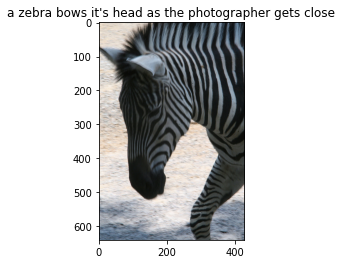

Caption length: tensor([12])


In [ ]:
data = CocoDataset(IMG_PATH, ANOT_PATH, transform = transforms.ToTensor(), 
                   target_transform = lambda x: torch.Tensor(x))

test_data = data[0]
plot_torch_img(opposite_split(test_data[1]), test_data[0])
print("Caption length:", test_data[-2])

## Defining the model

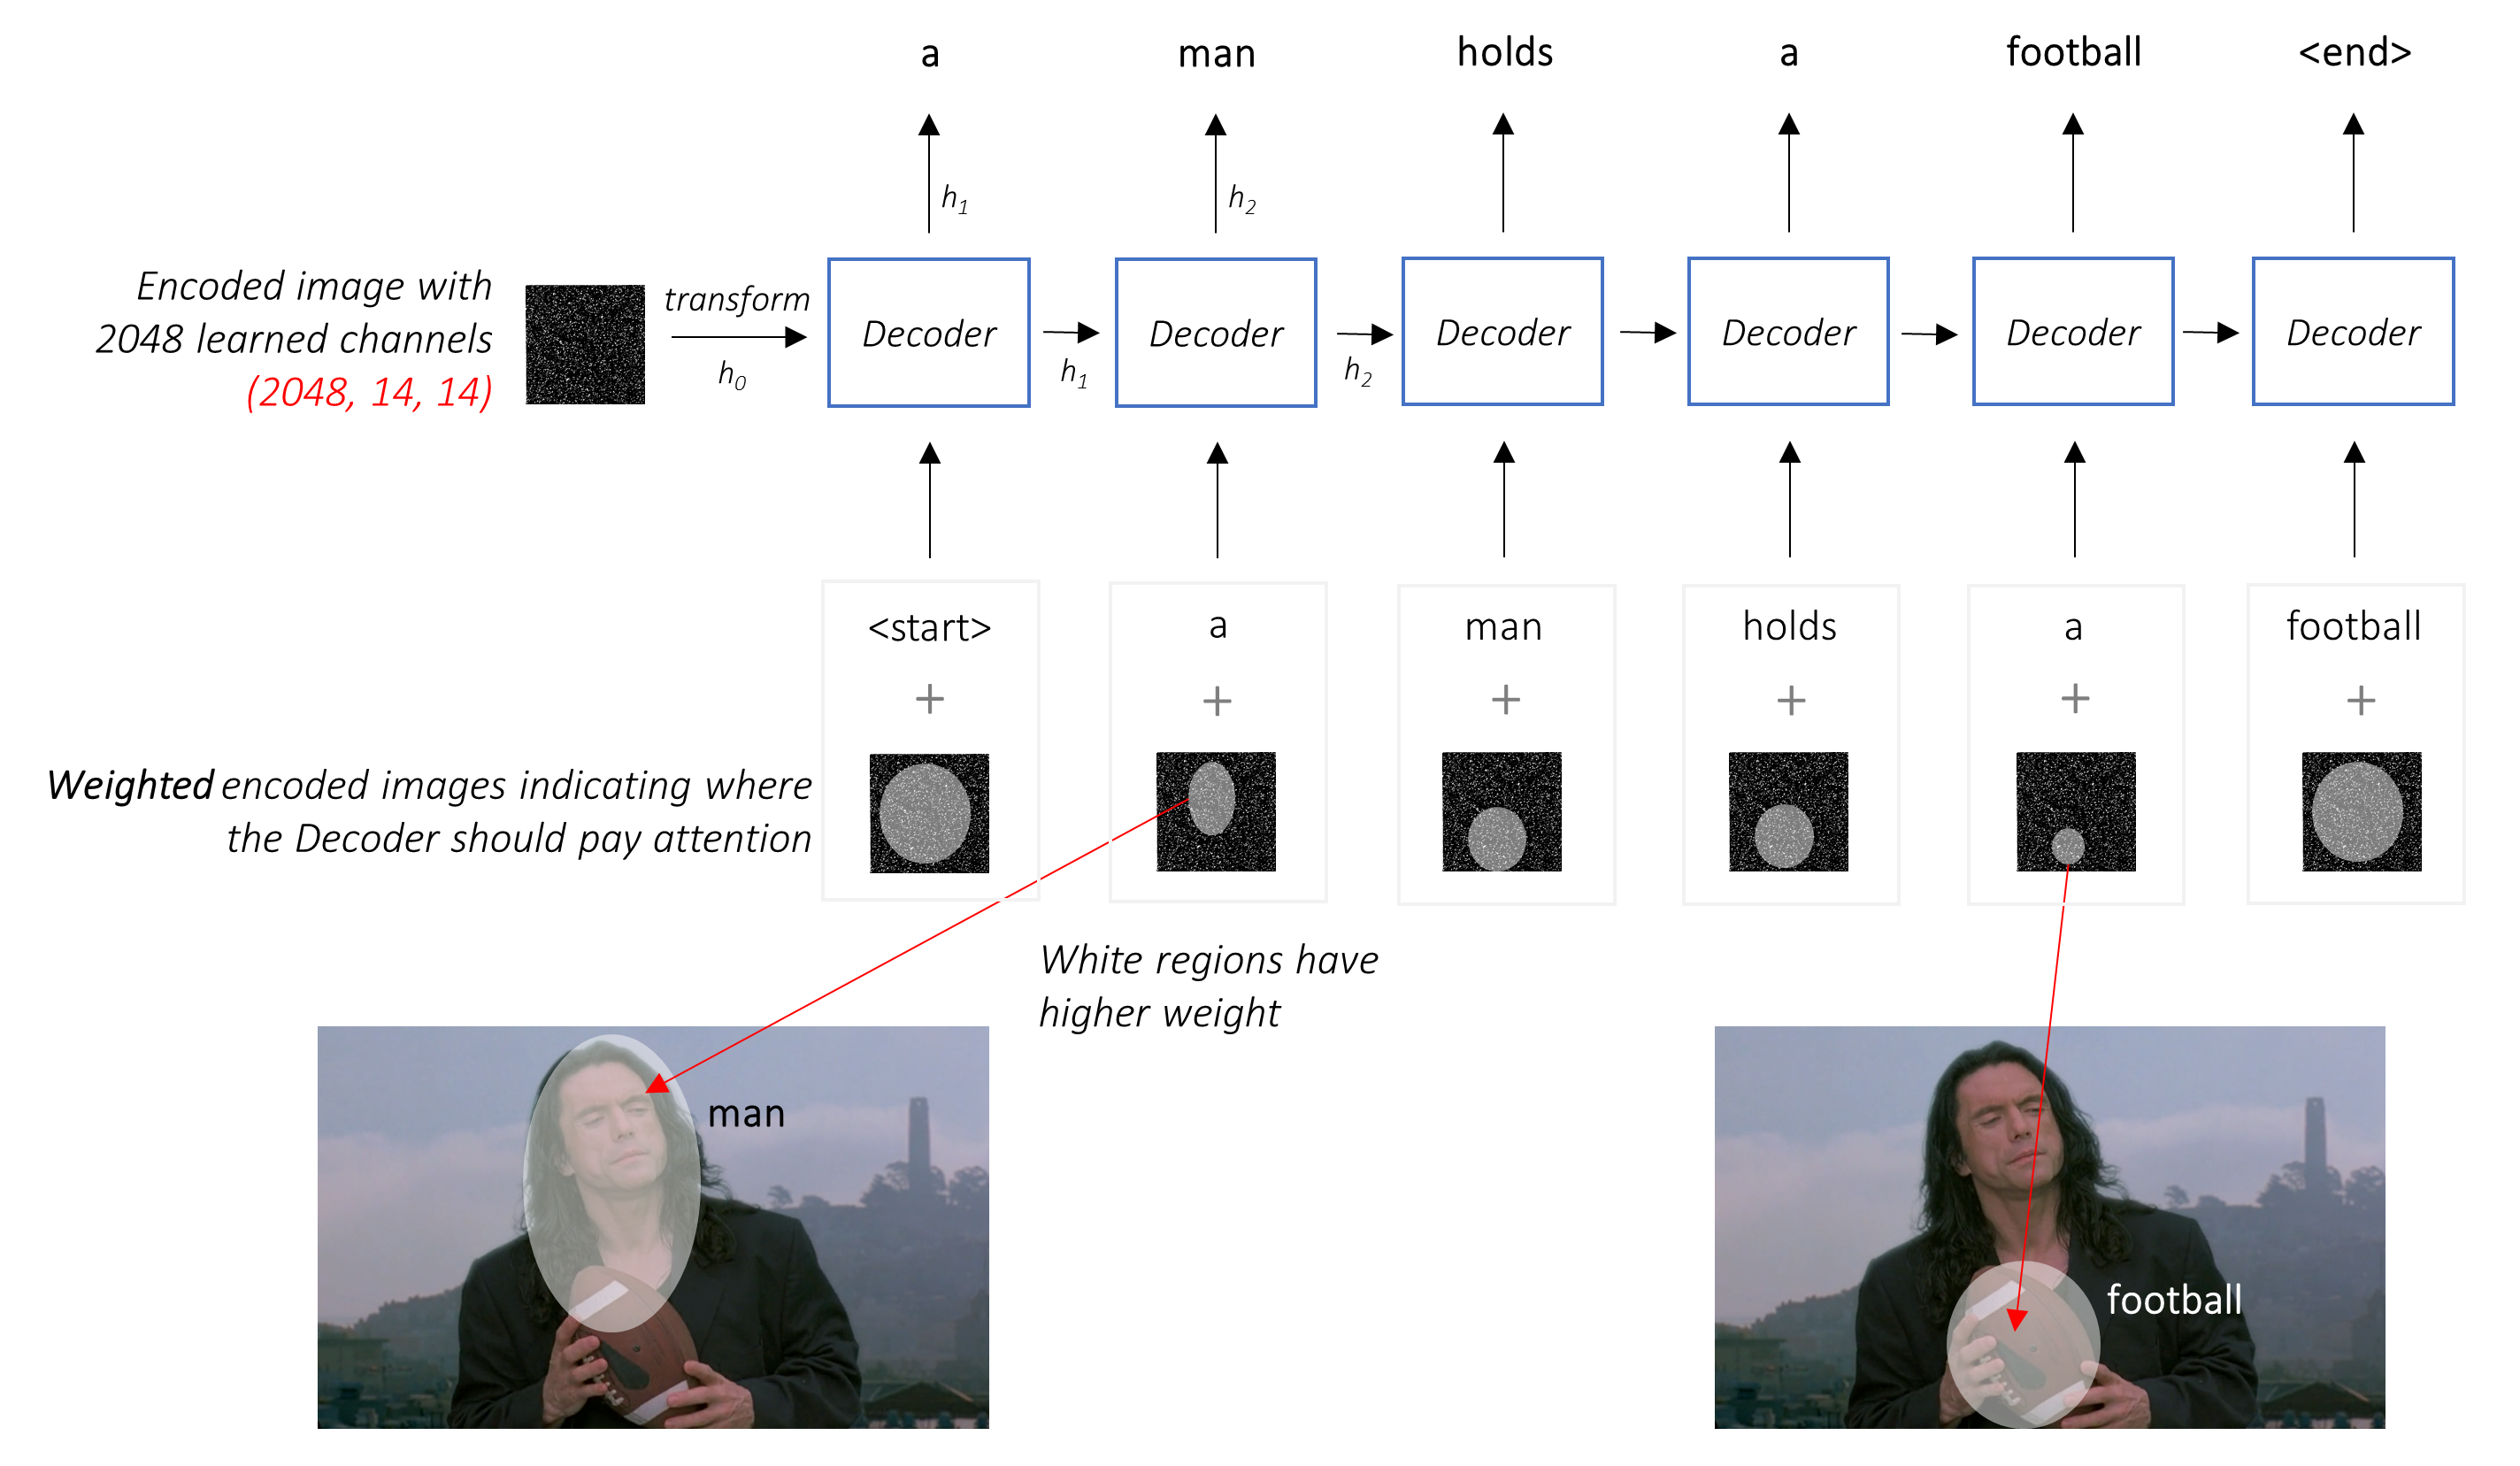

In this second notebook, the model is based on an attention mechanism that is adapted to computer vision tasks. The encoding process is exactly the same as our baseline model, meaning a pretrained resnet CNN to extract features maps of shape (batch_size, 14, 14, 2048). The decoding process is where changes come. We use a LSTM with attention. In details, it follows these steps:
- For each decoding timestep $t$:
  - We pass the encoder's output and the previous hidden state $h_{t-1}$ through an Attention Layer. We recall that the flattened encoder output has shape (batch_size, 14$\times$14, 2048), and decoder's previous hidden state has shape (batch_size, decoder_dim). These elements are both projected onto a space of dimension `attention_dim` thanks to a fully connected. It gives us features of respective shapes (batch_size, 14$\times$14, attention_dim) and (batch_size, attention_dim). These features are additioned, passed through a feedforward+softmax, which leads to an output shape of (batch_size, num_pixels) for the attention weights. We also apply these attention weights to the encoder output by multiplying them and summing on the `num_pixels` dimension, which leads to another output of shape (batch_size, encoder_dim). The outputs of the attention layer have shapes (batch_size, num_pixels) for the attention weights, and (batch_size, encoder_dim) for the encoder output with applied weights.
  - We apply an LSTM cell which has the following inputs:
    - Input at time $t$: concatenated attention weighted encoded image+word at time $t$ (**see figure above**).
    - Previous hidden and cell states $h_{t-1}$ and $c_{t-1}$.

    we then retrieve the next hidden state $h_t$ and cell state $c_t$.
  - We store the word prediction by applying a fully connected + dropout of output shape `vocab_size` to the hidden state.
  - We repeat the process until maximum caption length.


In [ ]:
import torchvision
import torch.nn as nn
import torch


class Encoder(nn.Module):
    """ Encoder """
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (the two last layers because we want the features)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # We don't want our model to optimize the encoder
        for p in self.resnet.parameters():
            p.requires_grad = False

    def forward(self, images):
        """Forward propagation
           :param images: torch images to encode"""
        out = self.resnet(images)  # dim = (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # dim = (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # dim = (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out


class Attention(nn.Module):
    """Attention Block"""
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """:param encoder_dim: feature size of encoded images
           :param decoder_dim: size of decoder's RNN
           :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """Forward propagation"""
        att1 = self.encoder_att(encoder_out)  # dim=(batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # dim=(batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # dim=(batch_size, num_pixels)
        alpha = self.softmax(att)  # dim=(batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # dim=(batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """Decoder"""

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim=2048, dropout=0.5):
        """:param attention_dim: size of attention network
           :param embed_dim: embedding size
           :param decoder_dim: size of decoder's RNN
           :param vocab_size: size of vocabulary
           :param encoder_dim: feature size of encoded images
           :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """Initializes embedding and linear layer with uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """ Loads embedding layer with pre-trained embeddings.
            :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """ Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
            :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """ Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
            :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
            :param hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """ Forward propagation.
            :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
            :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
            :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
            :return scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # ------------
        # ENCODER FEATURE: convolved image
        # ------------

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # ------------
        # CAPTION FEATURE: vector of max length 51 for Coco dataset
        # ------------

        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        encoded_captions = torch.tensor(encoded_captions).to(torch.int64)

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(self.device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding # (batch_size_t, encoder_dim)
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

We can have a look at our model structure and trainable parameters.

In [ ]:
from torchsummary import summary

dec = DecoderWithAttention(attention_dim=512, embed_dim=512,
                                   decoder_dim=512, vocab_size=len(word_map),
                                   dropout=0.5, device=device).to(device)
enc = Encoder().to(device)

summary(enc, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
print(dec)

DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(36303, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2560, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=36303, bias=True)
)


## Training and evaluation loop

The training and evaluation loop are almost similar as in the previous notebook. The difference is that we will evaluate with the BLEU-4 score during the loop. We will also store the best model at each epoch as a checkpoint.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)


def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, '/content/drive/MyDrive/BEST_' + filename)


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """ Performs one epoch's training.
        Params
            train_loader: DataLoader for training data
            encoder: encoder model
            decoder: decoder model
            criterion: loss layer
            encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
            decoder_optimizer: optimizer to update decoder's weights
            epoch: epoch number
    """
    global device

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, _, caps, caplens, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)                                                                 # encoder step: imgs has shape (batch_size, encoded_image_size, encoded_image_size, 2048)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens) # decoder step: scores has shape (batch_size, max_len, vocab_size)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]                                                         # (batch_size, 50)

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this                                 
        scores, _, _, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)     # (size of all flattened 
                                                                                             # sentences in batch without pad,vocab_size)
        targets, _, _, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)   # (size of all flattened 
                                                                                             # sentences in batch without pad)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion, word_map):
    """Performs one epoch's validation.
       Params:
          val_loader: DataLoader for validation data.
          encoder: encoder model
          decoder: decoder model
          criterion: loss layer
       Returns: 
          BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    with torch.no_grad():
        # Batches
        for i, (imgs, _, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)                                                             # encoder step: imgs has shape (batch_size, encoded_image_size, encoded_image_size, 2048)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens) # decoder step: scores has shape (batch_size, max_len, vocab_size)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]                                                         # (batch_size, 50)

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _, _, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)     # (size of all flattened 
                                                                                                 # sentences in batch without pad,vocab_size)
            targets, _, _, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)   # (size of all flattened 
                                                                                                 # sentences in batch without pad)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4


def main():
  global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, device

  data_train = CocoDataset(IMG_PATH, ANOT_PATH, transform = transformer,
                     target_transform=lambda x: torch.LongTensor(x),
                     data_train=True)
  data_val = CocoDataset(IMG_PATH, ANOT_PATH, transform = transformer,
                     target_transform=lambda x: torch.LongTensor(x),
                     data_train=False)
  train_loader = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=1)
  val_loader = DataLoader(data_val, batch_size=16, shuffle=True, num_workers=1)
  max_len = int(data.encoder.max_len)

  word_map = data_train.encoder.word_map

  # Initialize / load checkpoint
  if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim=attention_dim, embed_dim=emb_dim,
                                   decoder_dim=decoder_dim, vocab_size=len(word_map),
                                   dropout=dropout, device=device)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
    encoder = Encoder()
    encoder_optimizer = None

  else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    if best_bleu4 is None:
        best_bleu4 = 0
    decoder = checkpoint['decoder']
    decoder.device = device
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']

  # Move to GPU, if available
  decoder = decoder.to(device)
  encoder = encoder.to(device)

  # Loss function
  criterion = nn.CrossEntropyLoss().to(device)

  for epoch in range(start_epoch, epochs):
      # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
      if epochs_since_improvement == 20:
          break
      if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
          adjust_learning_rate(decoder_optimizer, 0.8)
          if fine_tune_encoder:
              adjust_learning_rate(encoder_optimizer, 0.8)

      # One epoch's training
      train(train_loader=train_loader, encoder=encoder, decoder=decoder,
            criterion=criterion, encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer, epoch=epoch)
      
      # One epoch's validation
      recent_bleu4 = validate(val_loader=val_loader, encoder=encoder,
                              decoder=decoder, criterion=criterion, word_map=word_map)

      # Check if there was an improvement
      is_best = recent_bleu4 > best_bleu4
      best_bleu4 = max(recent_bleu4, best_bleu4)
      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
      else:
          epochs_since_improvement = 0
      
      # Save checkpoint
      save_checkpoint("coco2017", epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                      decoder_optimizer, best_bleu4, is_best)

In [ ]:
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
fine_tune_encoder = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
transformer = transforms.Compose([lambda x: x.resize((256,256)), transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])

# Training parameters
start_epoch = 0
epochs = 40  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 16
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
checkpoint = None # "/content/drive/MyDrive/BEST_checkpoint_coco2017.pth.tar"  # path to checkpoint, None if none

In [ ]:
main()

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: [0][0/417]	Batch Time 0.739 (0.739)	Data Load Time 0.520 (0.520)	Loss 11.4446 (11.4446)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/417]	Batch Time 0.196 (0.214)	Data Load Time 0.043 (0.055)	Loss 6.5455 (7.3337)	Top-5 Accuracy 33.880 (32.553)
Epoch: [0][200/417]	Batch Time 0.191 (0.209)	Data Load Time 0.034 (0.051)	Loss 6.0671 (6.7393)	Top-5 Accuracy 38.889 (35.980)
Epoch: [0][300/417]	Batch Time 0.210 (0.207)	Data Load Time 0.058 (0.050)	Loss 5.4045 (6.4022)	Top-5 Accuracy 47.826 (38.846)
Epoch: [0][400/417]	Batch Time 0.194 (0.206)	Data Load Time 0.046 (0.049)	Loss 5.5437 (6.1911)	Top-5 Accuracy 46.023 (40.843)
Validation: [0/209]	Batch Time 0.410 (0.410)	Loss 5.5196 (5.5196)	Top-5 Accuracy 48.913 (48.913)	
Validation: [100/209]	Batch Time 0.200 (0.203)	Loss 5.0731 (5.3328)	Top-5 Accuracy 57.062 (50.200)	
Validation: [200/209]	Batch Time 0.198 (0.200)	Loss 5.4082 (5.3179)	Top-5 Accuracy 49.189 (50.409)	

 * LOSS - 5.315, TOP-5 ACCURACY - 50.411, BLEU-4 - 0.06096213038028625



/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DecoderWithAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/417]	Batch Time 2.171 (2.171)	Data Load Time 1.957 (1.957)	Loss 5.1992 (5.1992)	Top-5 Accuracy 54.348 (54.348)
Epoch: [1][100/417]	Batch Time 0.179 (0.206)	Data Load Time 0.030 (0.048)	Loss 4.9921 (5.3411)	Top-5 Accuracy 53.409 (50.078)
Epoch: [1][200/417]	Batch Time 0.168 (0.191)	Data Load Time 0.007 (0.034)	Loss 4.9054 (5.2796)	Top-5 Accuracy 57.513 (50.708)
Epoch: [1][300/417]	Batch Time 0.157 (0.187)	Data Load Time 0.003 (0.030)	Loss 5.0580 (5.2166)	Top-5 Accuracy 55.914 (51.411)
Epoch: [1][400/417]	Batch Time 0.167 (0.184)	Data Load Time 0.020 (0.028)	Loss 4.8112 (5.1678)	Top-5 Accuracy 50.000 (51.968)
Validation: [0/209]	Batch Time 0.392 (0.392)	Loss 4.9576 (4.9576)	Top-5 Accuracy 55.263 (55.263)	
Validation: [100/209]	Batch Time 0.183 (0.177)	Loss 5.3198 (4.8746)	Top-5 Accuracy 51.872 (56.636)	
Validation: [200/209]	Batch Time 0.170 (0.176)	Loss 5.3921 (4.9095)	Top-5 Accuracy 51.366 (56.044)	

 * LOSS - 4.907, TOP-5 ACCURACY - 56.112, BLEU-4 - 0.09835161155928632

E

## Inference with beam search

The beam search algorithm has been explained in the previous notebook and relies on the intuitive idea of choosing the best sentence amongst $k$ predictions, word by word.

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/BEST_checkpoint_coco2017.pth.tar")

decoder = checkpoint['decoder']
encoder = checkpoint['encoder']

img_path = ["/content/train2017/" + i for i in os.listdir("/content/train2017/")]
inv_word_map = {x:i for i,x in data.encoder.word_map.items()}

In [ ]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, device, beam_size=3):
    """ Reads an image and captions it with beam search.
        :param encoder: encoder model
        :param decoder: decoder model
        :param image_path: path to image
        :param word_map: word map
        :param beam_size: number of sequences to consider at each decode-step
        :return caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = np.array(Image.open(image_path).convert('RGB').resize((256, 256)))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.ToTensor(), normalize])
    image = transform(img).to(device)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            print("reached")
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas, img

We can now have a look at predictions on the training data. We will then predict on new images to judge the generalization ability of our model.

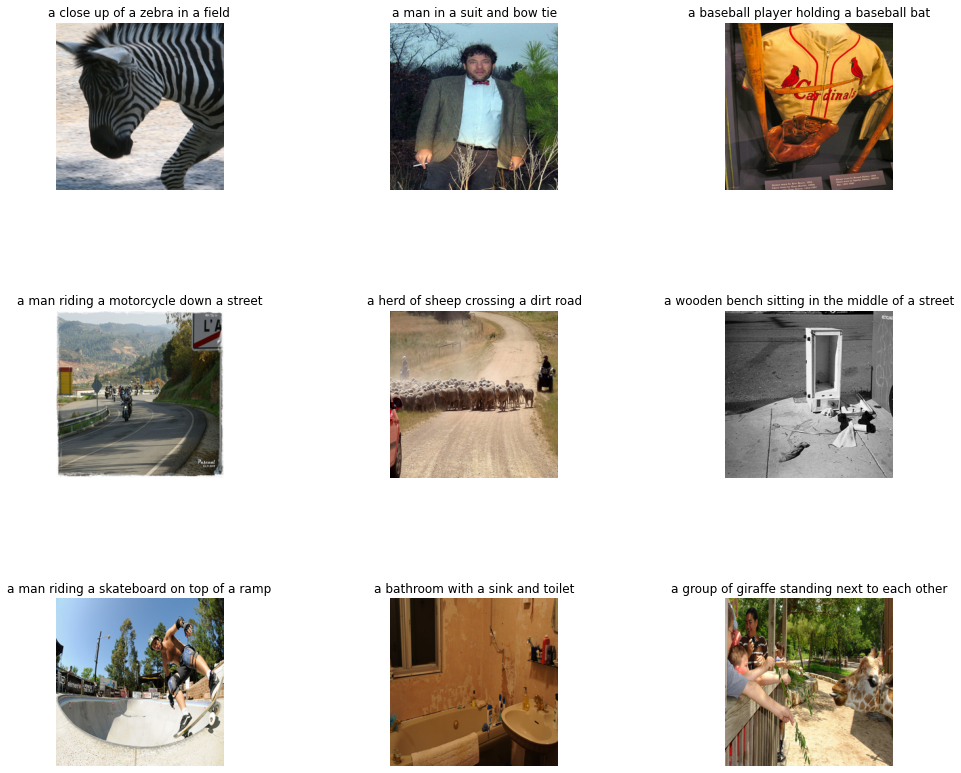

In [ ]:
f, axs = plt.subplots(3,3,figsize=(15,15))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

for i in range(9):
  seq, alphas, img = caption_image_beam_search(encoder, decoder, img_path[i],
                                               data.encoder.word_map, device=device,
                                               beam_size=3)
  pred = [inv_word_map[i] for i in seq[1:-1]]
  axs[i % 3,i // 3].imshow(img)
  axs[i % 3,i // 3].set_title(opposite_split(pred))
  axs[i % 3,i // 3].axis('off')
  
plt.savefig("cap_generation_1.jpg")

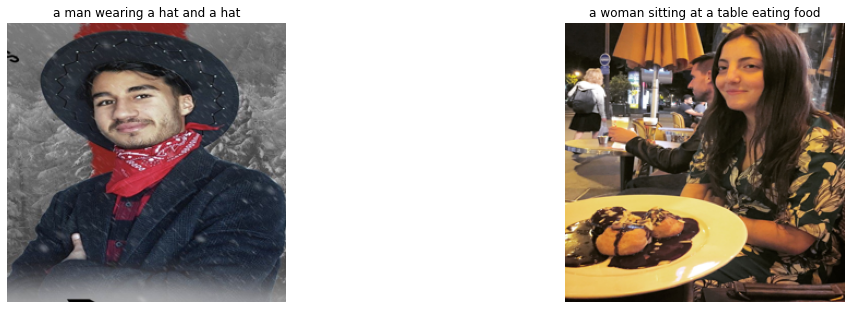

In [ ]:
paths = ['/content/drive/MyDrive/ryan.jpg','/content/drive/MyDrive/emma.jpg']
fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

for k in range(2):
  seq, alphas, img = caption_image_beam_search(encoder, decoder, paths[k],
                                               data.encoder.word_map, device=device,
                                               beam_size=3)
  pred = [inv_word_map[i] for i in seq[1:-1]]
  axes[k].imshow(img)
  axes[k].set_title(opposite_split(pred))
  axes[k].axis('off')

As we can see, the results are pretty impressive. Our model still makes some mistake, notably on the "a hat" repetition on Ryan's picture. To improve the results, we could try to tune the hyperparameters and/or increase the number of epochs.

## Visualizing the attention weights

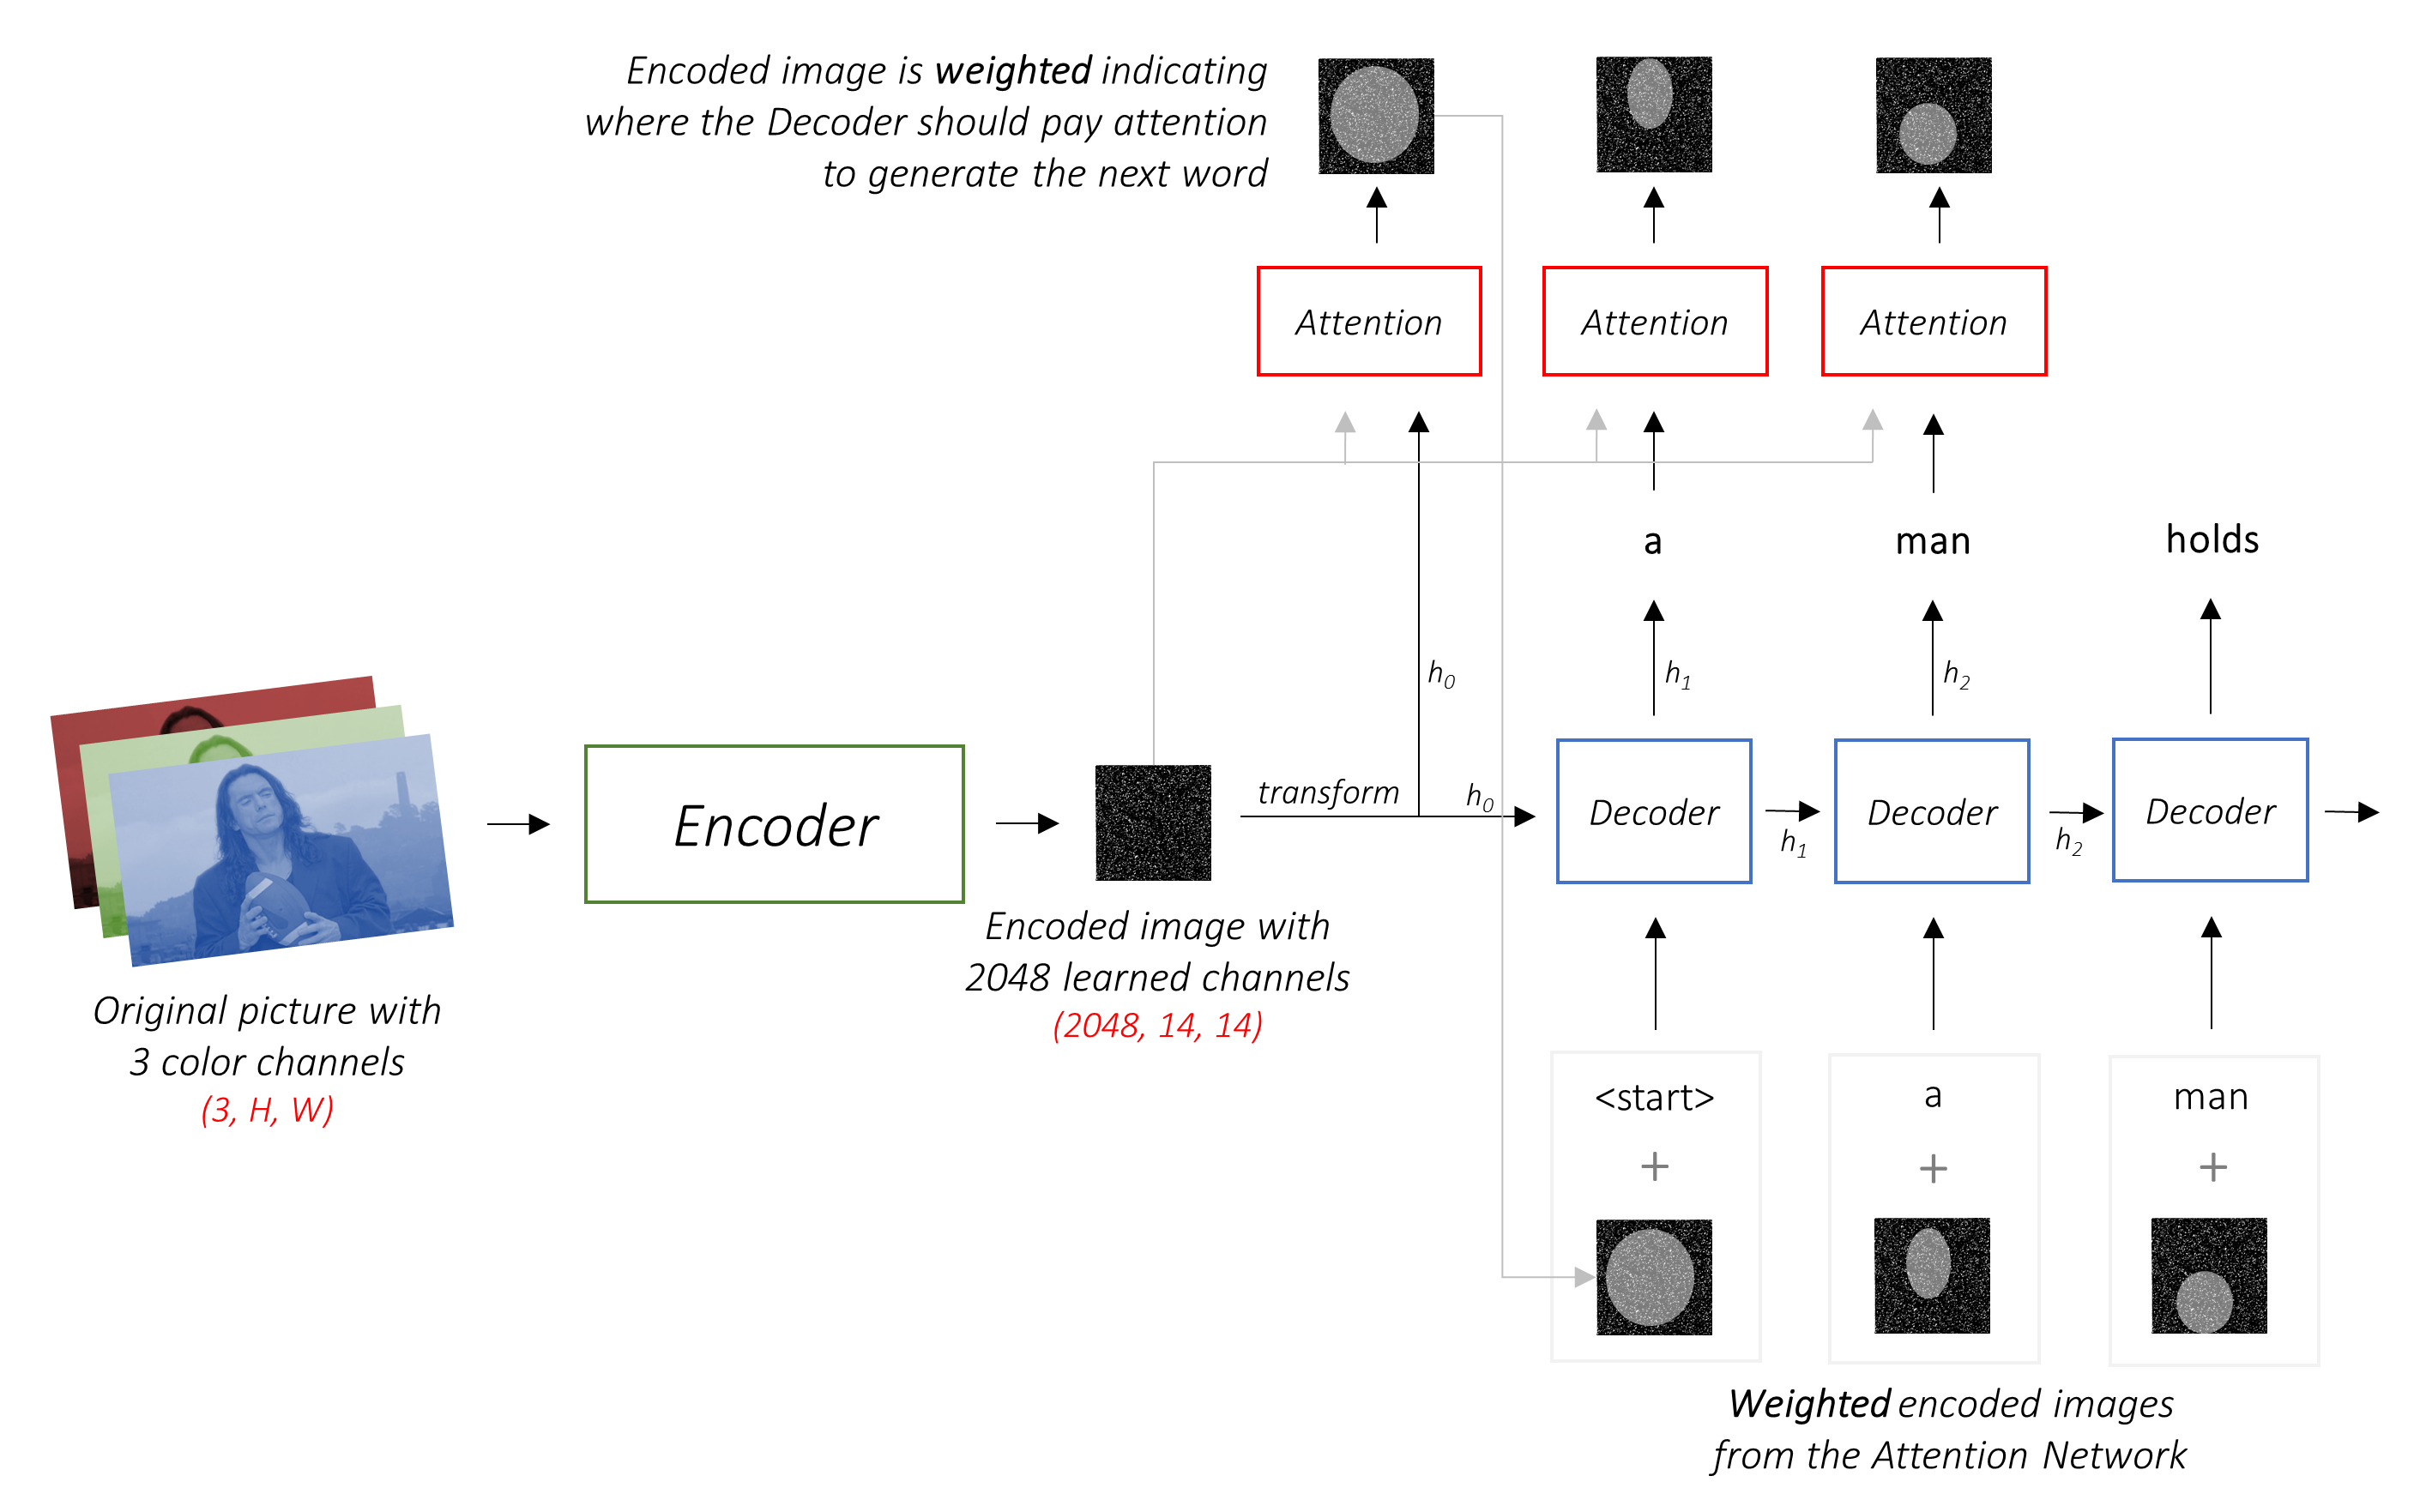

We can have a look at the attention weights that are computed during training. We recall that in the original paper, the idea of the the visual attention mechanism is that the encoded image, together with the hidden state at each timestep are projected onto a space of dimension equal to `attention_dim` through a feedforward neural network. These projections are additioned, and passed through a final neural network + softmax to obtain an output of size (batch_size, num_pixels), with weighted regions. The following code is retrieved from the repository of the authors' paper.

In [ ]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    import skimage.transform
    import matplotlib.cm as cm

    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    f, axs = plt.subplots(np.int(np.ceil(len(words) / 5.)), 5, figsize=(15, 10))
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0)

    for t in range(len(words)):
        if t > 50:
            break
        axs[t // 5, t % 5].text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        axs[t // 5, t % 5].imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            axs[t // 5, t % 5].imshow(alpha, alpha=0, cmap=cm.Greys_r)
        else:
            axs[t // 5, t % 5].imshow(alpha, alpha=0.8, cmap=cm.Greys_r)
        axs[t // 5, t % 5].axis('off')

    for t in range(np.int(np.ceil(len(words) / 5.)) * 5):
        axs[t // 5, t % 5].axis('off')
    plt.savefig("ATT.jpg")
    plt.show()

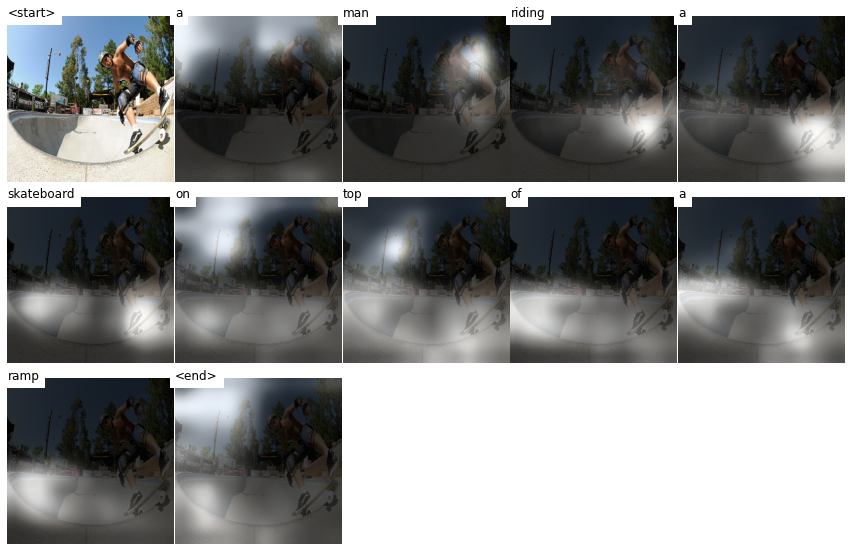

In [ ]:
seq, alphas, img = caption_image_beam_search(encoder, decoder, img_path[2], data.encoder.word_map, device, beam_size=3)
alphas = torch.tensor(alphas)
visualize_att(img_path[2], seq, alphas, inv_word_map, smooth=True)

Note that the pictures have a lag of 1 with respect to the predicted caption as in the true algorithm, weighted attention is computed for the **next word**. In the above example, the computed weights are coherent with the caption: for instance, we can clearly see a focus on the true man on the image when the word "man" is predicted, while "riding" is also predicted focusing on the feet of the man in the picture.